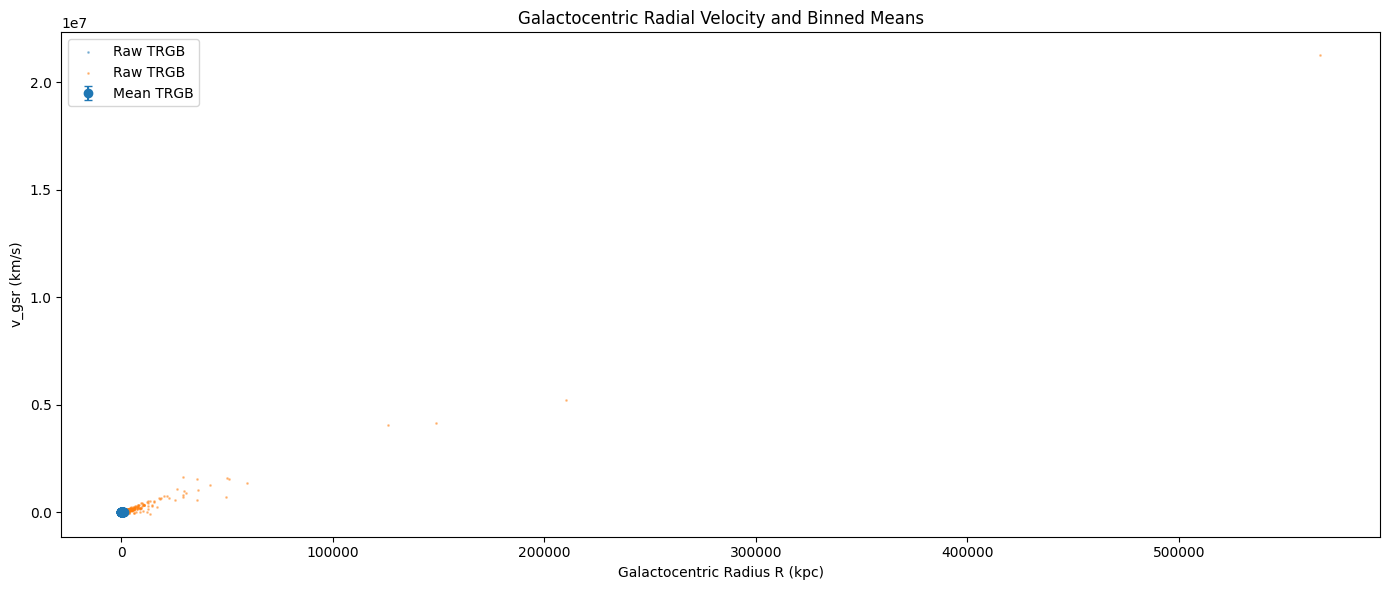

In [2]:
import numpy as np
import pandas as pd
import astropy.units as u
from astropy.coordinates import SkyCoord, Galactocentric
from scipy.stats import binned_statistic
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from astropy.stats import sigma_clip
# ------------------------------
# Constants
# ------------------------------
U_sun, V_sun, W_sun = 11.1 * u.km/u.s, 12.24 * u.km/u.s, 7.25 * u.km/u.s
V0, R0 = 229 * u.km/u.s, 8.1 * u.kpc
z_sun = 0.020 * u.kpc

# ------------------------------
# Galactocentric Transformation + Velocity Extraction
# ------------------------------
def transform_to_galactocentric(ra, dec, distance, pm_ra_cosdec, pm_dec, rv):
    icrs = SkyCoord(ra=ra, dec=dec, distance=distance,
                    pm_ra_cosdec=pm_ra_cosdec, pm_dec=pm_dec,
                    radial_velocity=rv)
    galcen = icrs.transform_to(
        Galactocentric(galcen_distance=R0, z_sun=z_sun,
                       galcen_v_sun=[U_sun, V_sun, W_sun])
    )
    X, Y, Z = galcen.x.value, galcen.y.value, galcen.z.value
    U, V, W = galcen.v_x.value, galcen.v_y.value, galcen.v_z.value
    r = np.sqrt(X**2 + Y**2 + Z**2)
    phi = np.arctan2(Y, X)
    theta = np.pi / 2 - np.arctan2(Z, np.sqrt(X**2 + Y**2))
    V_r = (U * np.cos(phi) + V * np.sin(phi)) * np.sin(theta) + W * np.cos(theta)
    V_theta = (U * np.cos(phi) + V * np.sin(phi)) * np.cos(theta) - W * np.sin(theta)
    V_phi = U * np.sin(phi) - V * np.cos(phi)
    R_xy = np.sqrt(X**2 + Y**2+Z**2)
    return r, Z, V_r, V_theta, V_phi, R_xy, rv

# ------------------------------
# Rotation Curve Processing
# ------------------------------
import numpy as np
import pandas as pd
import astropy.units as u
from scipy.stats import binned_statistic

def process_file_with_selection(file_path, label, custom_bins):
    # 1. Load and clean
    df = pd.read_csv(file_path)
    required_cols = [
        'ra', 'dec', 'parallax', 'pmra', 'pmdec',
        'radial_velocity', 'l', 'b', 'parallax_error'
    ]
    df = df.dropna(subset=required_cols)
    # df = df[(df['bp_rp'] > 0) & (df['bp_rp'] >0)]

    # 2. Convert to astropy quantities
    ra = df['ra'].values * u.deg
    dec = df['dec'].values * u.deg
    distance = (df['parallax'].values * u.mas).to(u.kpc, u.parallax())
    pm_ra_cosdec = df['pmra'].values * u.mas/u.yr
    pm_dec = df['pmdec'].values * u.mas/u.yr
    rv = df['radial_velocity'].values * u.km/u.s
    l = df['l'].values * u.deg
    b = df['b'].values * u.deg

    # 3. Transform to Galactocentric (assumes you have this function defined)
    r, z, V_r, V_theta, V_phi, R_xy, rv = transform_to_galactocentric(
        ra, dec, distance, pm_ra_cosdec, pm_dec, rv
    )

    clip_Vr = sigma_clip(V_r, sigma=3, maxiters=5)
    clip_Vt = sigma_clip(V_theta, sigma=3, maxiters=5)
    clip_Vp = sigma_clip(V_phi, sigma=3, maxiters=5)
    # 4. Spatial and velocity sigma clipping & (clip_Vr.mask | clip_Vt.mask | clip_Vp.mask)
    spatial_mask = (np.abs(z)>5)&~(z<-3) 

    # Prepare spatial velocities for anisotropy calculation
    r_spatial = r[spatial_mask]
    V_r_spatial = V_r[spatial_mask]
    V_th_spatial = V_theta[spatial_mask]
    V_ph_spatial = V_phi[spatial_mask]
    R_valid = R_xy[spatial_mask]
    rv_valid = rv[spatial_mask].value
    l_valid = l[spatial_mask]
    b_valid = b[spatial_mask]
    distance_valid = distance[spatial_mask]

    # 5. Compute V_gsr and V_circ
    v_gsr = (rv_valid
             + U_sun.value * np.cos(b_valid) * np.cos(l_valid)
             + V_sun.value * np.cos(b_valid) * np.sin(l_valid)
             + W_sun.value * np.sin(b_valid)
             + V0.value * np.cos(b_valid) * np.sin(l_valid))

    v_circ = (R_valid / R0.value) * ((v_gsr / (np.sin(l_valid) * np.cos(b_valid))) + V0.value)


    # 6. Bin statistics on V_gsr with custom bins
    mask = ~np.isnan(r_spatial) & ~np.isnan(v_gsr) & (r_spatial <= custom_bins[-1])
    R_valid_clean, v_gsr_clean = r_spatial[mask], v_gsr[mask]

    mean_x, _, _ = binned_statistic(R_valid_clean, R_valid_clean, bins=custom_bins, statistic='mean')
    mean_y, _, _ = binned_statistic(R_valid_clean, v_gsr_clean, bins=custom_bins, statistic='mean')
    std_y, _, _ = binned_statistic(R_valid_clean, v_gsr_clean, bins=custom_bins, statistic='std')
    count, _, _ = binned_statistic(R_valid_clean, v_gsr_clean, bins=custom_bins, statistic='count')
    bin_centers = 0.5 * (custom_bins[:-1] + custom_bins[1:])



    # 7. Robust dispersion estimator
    def robust_sigma(data):
        y = np.array(data, dtype=float).ravel()
        if y.size == 0:
            return np.nan
        y0 = np.median(y)
        mad = np.median(np.abs(y - y0)) / 0.6745
        if mad < 1e-20:
            mad = np.mean(np.abs(y - y0)) / 0.80
        u = (y - y0) / (6.0 * mad)
        mask_u = np.abs(u) <= 1.0
        if mask_u.sum() < 3:
            return np.nan
        u2 = u[mask_u]**2
        y_core = y[mask_u]
        num = np.sum((y_core - y0)**2 * (1 - u2)**4)
        den = np.sum((1 - u2) * (1 - 5.0 * u2))
        sigma2 = len(y) * num / (den * (den - 1))
        return np.sqrt(sigma2) if sigma2 > 0 else 0.0

    # 8. Compute binned stats for velocity components using custom bins
    def compute_binned_stats_custom(r, v, bins):
        stats = []
        for i in range(len(bins) - 1):
            mask = (r >= bins[i]) & (r < bins[i + 1])
            if np.sum(mask) >= 3:
                v_bin = v[mask]
                sig = robust_sigma(v_bin)
                err = sig / np.sqrt(2 * (np.sum(mask) - 1))
                med = np.median(v_bin)
            else:
                sig = err = med = np.nan
            stats.append((med, sig, err))
        return np.array(stats).T

    medVr, sigVr, errVr = compute_binned_stats_custom(r_spatial, V_r_spatial, custom_bins)
    medVt, sigVt, errVt = compute_binned_stats_custom(r_spatial, V_th_spatial, custom_bins)
    medVp, sigVp, errVp = compute_binned_stats_custom(r_spatial, V_ph_spatial, custom_bins)

    # 9. Anisotropy beta and error propagation
    beta = 1 - (sigVt**2 + sigVp**2) / (2 * sigVr**2)
    d_beta_dsr = (sigVt**2 + sigVp**2) / (sigVr**3)
    d_beta_dst = -sigVt / (sigVr**2)
    d_beta_dsp = -sigVp / (sigVr**2)
    beta_err = np.sqrt((d_beta_dsr * errVr)**2 +
                       (d_beta_dst * errVt)**2 +
                       (d_beta_dsp * errVp)**2)

    # 10. Return results
    return R_valid_clean, v_gsr_clean, pd.DataFrame({
        'Bin Center': bin_centers,
        'Mean X': mean_x,
        'Mean Y': mean_y,
        'Std Y': std_y,
        'Num Points': count,
        'Beta': beta,
        'Beta Error': beta_err,
        'Label': label,
    }).dropna(),r, z, V_r_spatial, V_th_spatial, V_ph_spatial,r_spatial





def power_law(x, a, b):
    return a * (x / 50)**b


file_configs = [
    {
        'path': 'LPV_Gaia_new-result.csv', 'label': 'TRGB',
        'bins': np.concatenate([
            np.linspace(8, 100, 18), np.linspace(100, 150, 10)[1:], np.linspace(150, 200, 10)[1:],
            np.linspace(200, 400, 10)[1:], np.linspace(400, 600, 8)[1:],
            np.linspace(600, 800, 5)[1:], np.linspace(800, 1000, 3)[1:], np.linspace(1000, 1200, 2)[1:]
        ])
    },
    # {
    #     'path': 'LPV_Gaia_new-result.csv', 'label': 'LPV',
    #     'bins': np.concatenate([
    #         np.linspace(8, 100, 18), np.linspace(100, 150, 10)[1:], np.linspace(150, 200, 10)[1:],
    #         np.linspace(200, 400, 10)[1:], np.linspace(400, 600, 8)[1:],
    #         np.linspace(600, 800, 5)[1:], np.linspace(800, 1000, 3)[1:], np.linspace(1000, 1200, 2)[1:]
    #     ])
    # }
]

# Plot 1: v_gsr and binned means
plt.figure(figsize=(14, 6))
for config in file_configs:
    R, v_gsr, binned,r, z, V_r, V_theta, V_phi , r_spatial = process_file_with_selection(config['path'], config['label'], config['bins'])
    plt.scatter(R, v_gsr, s=1, alpha=0.4, label=f'Raw {config["label"]}')
    plt.scatter(r_spatial, V_phi, s=1, alpha=0.4, label=f'Raw {config["label"]}')
    plt.xlim=(0, 200)

    plt.errorbar(binned['Mean X'], binned['Mean Y'], yerr=binned['Std Y'], fmt='o', capsize=3, label=f'Mean {config["label"]}')
plt.xlabel('Galactocentric Radius R (kpc)')
plt.ylabel('v_gsr (km/s)')
plt.title('Galactocentric Radial Velocity and Binned Means')

plt.legend()
plt.tight_layout()
plt.show()

# # Normalized Count plots and fits
# fit_params_ntr, fit_params_sigma, fit_params = [], [], {}
# fig3, ax3 = plt.subplots(figsize=(12, 5))
# fig4, ax4 = plt.subplots(figsize=(12, 5))
# colors = ['tab:blue', 'tab:orange']

# for i, config in enumerate(file_configs):
#     R, v_gsr, binned_df ,r, z, V_r, V_theta, V_phi ,r_spatial= process_file_with_selection(config['path'], config['label'], config['bins'])
#     color = colors[i % len(colors)]
#     r_bin = binned_df['Bin Center'].values
#     n_tr = binned_df['Num Points'].values / len(R)
#     valid_mask = r_bin >= 25
#     r_bin_valid, n_tr_valid = r_bin[valid_mask], n_tr[valid_mask]
#     r_bin_low, n_tr_low = r_bin_valid[r_bin_valid < 200], n_tr_valid[r_bin_valid < 200]
#     r_bin_high, n_tr_high = r_bin_valid[r_bin_valid >= 200], n_tr_valid[r_bin_valid >= 200]
#     popt_low, _ = curve_fit(power_law, r_bin_low, n_tr_low, p0=(1, 1))
#     popt_high, _ = curve_fit(power_law, r_bin_high, n_tr_high, p0=(1, 1))
#     fit_params_ntr += [(config['label'], '<200', *popt_low), (config['label'], '≥200', *popt_high)]
#     fit_params[config['label']] = {'b_low': popt_low[1], 'b_high': popt_high[1]}
#     x_fit_low = np.linspace(r_bin_low.min(), r_bin_low.max(), 100)
#     x_fit_high = np.linspace(r_bin_high.min(), r_bin_high.max(), 100)
#     y_fit_low = power_law(x_fit_low, *popt_low)
#     y_fit_high = power_law(x_fit_high, *popt_high)
#     ax3.errorbar(r_bin_valid, n_tr_valid, yerr=np.sqrt(n_tr_valid/len(R)), fmt='o', capsize=3, label=f'{config["label"]}', color=color)
#     ax3.plot(x_fit_low, y_fit_low, '--', color=color)
#     ax3.plot(x_fit_high, y_fit_high, '-', color=color)
#     ax4.errorbar(r_bin_valid, n_tr_valid, yerr=np.sqrt(n_tr_valid/len(R)), fmt='o', capsize=3, label=f'{config["label"]}', color=color)
#     ax4.plot(x_fit_low, y_fit_low, '--', color=color)
#     ax4.plot(x_fit_high, y_fit_high, '-', color=color)

# for ax, title, ylab, xlog, ylog in zip([ax3, ax4], ['Normalized Count vs R', 'Normalized Count vs R (log-log)'], ['Normalized Count']*2, [False, True], [False, True]):
#     ax.set_xlabel('Galactocentric Radius R (kpc)')
#     ax.set_ylabel(ylab)
#     ax.set_title(title)
#     ax.legend()
#     ax.grid(True)
#     if xlog: ax.set_xscale('log')
#     if ylog: ax.set_yscale('log')
#     ax.set_xlim(10, 200)
# plt.tight_layout()
# plt.show()

# print("\nFitted Parameters for n_tr (Normalized Counts):")
# for label, region, a, b in fit_params_ntr:
#     print(f"[{label}] {region}: a = {a:.5e}, b = {b:.5f}")

# # Fit to Std Dev vs Radius
# fig_sigma, ax_sigma = plt.subplots(figsize=(10, 6))
# for config in file_configs:
#     _, _, binned,r, z, V_r, V_theta, V_phi,r_spatial = process_file_with_selection(config['path'], config['label'], config['bins'])
#     r_bin, s_gsr = binned['Bin Center'].values, binned['Std Y'].values
#     N = binned['Num Points'].values
#     error_bars = np.sqrt(1 / (2 * (N - 1))) * s_gsr
#     popt, _ = curve_fit(power_law, r_bin, s_gsr, p0=(1, 1))
#     fitted_a, fitted_b = popt
#     fit_params[config['label']]['b_s'] = fitted_b
#     x_fit, y_fit = np.linspace(min(r_bin), max(r_bin), 100), power_law(np.linspace(min(r_bin), max(r_bin), 100), fitted_a, fitted_b)
#     ax_sigma.errorbar(r_bin, s_gsr, yerr=error_bars, fmt='o', label=f'{config["label"]} Data', capsize=3)
#     ax_sigma.plot(x_fit, y_fit, label=f'{config["label"]} Fit: $y = {fitted_a:.2f} x^{{{fitted_b:.2f}}}$')
#     fit_params_sigma.append((config['label'], fitted_a, fitted_b))
# ax_sigma.set_xlabel('Galactocentric Radius (kpc)')
# ax_sigma.set_ylabel('Std Dev of $v_{gsr}$')
# ax_sigma.set_title('Power Law Fit to Std Dev vs Radius')
# ax_sigma.legend()
# ax_sigma.grid(True) 
# plt.tight_layout()
# plt.show()




In [33]:
len(V_phi)

11611

In [7]:
R, v_gsr, binned_df,r, z, V_r, V_theta, V_phi,r_spatial = process_file_with_selection(config['path'], config['label'], config['bins'])
binned_df

,Bin Center,Mean X,Mean Y,Std Y,Num Points,Beta,Beta Error,Label
0,10.705882,10.928574,-2.983574,110.268579,500.0,-0.651376,0.133998,TRGB
1,16.117647,16.125171,-6.000499,121.135756,577.0,-1.771213,0.215511,TRGB
2,21.529412,21.475336,2.735108,114.588287,638.0,-2.205317,0.235900,TRGB
3,26.941176,26.972358,-3.687613,114.660142,573.0,-4.325253,0.416917,TRGB
4,32.352941,32.282400,-10.076642,112.723057,566.0,-5.671339,0.527788,TRGB
5,37.764706,37.680575,-9.485765,120.087340,482.0,-6.549485,0.640196,TRGB
6,43.176471,43.132804,-7.689597,113.494739,493.0,-12.475118,1.120387,TRGB
7,48.588235,48.599223,-11.741917,119.807754,446.0,-13.314595,1.240218,TRGB
8,54.000000,53.937798,4.235142,117.151745,410.0,-19.794350,1.883396,TRGB
9,59.411765,59.315765,-10.244790,121.154922,378.0,-16.762808,1.662464,TRGB


3663

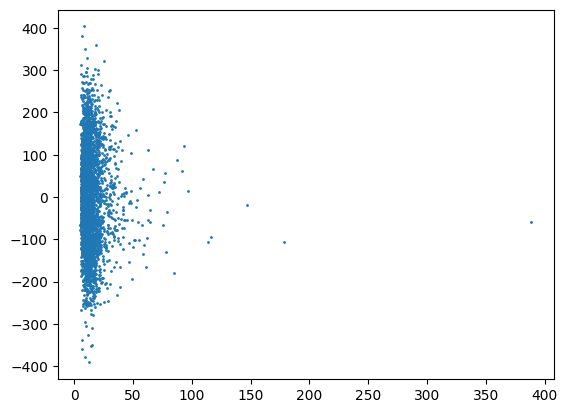

In [110]:
plt.scatter(r_spatial,v_gsr,s=1)



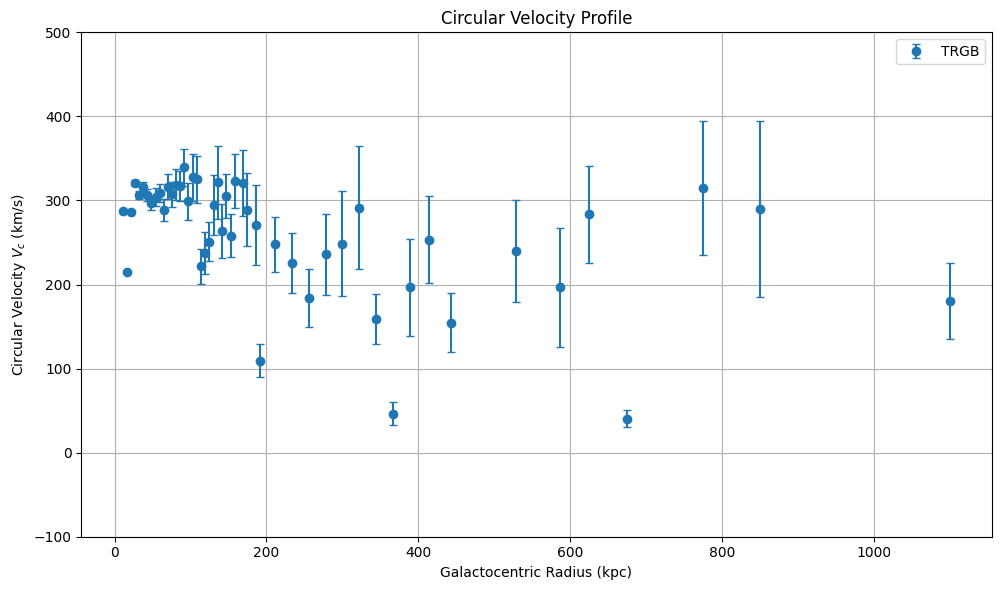

In [73]:
# V_c computation
def compute_v_c(r, std_y, N, b_low, b_high, b_s):
    H_r = (r**2 + R0**2) / (4 * r**2) - ((r**2 - R0**2)**2) / (8 * r**3 * R0) * np.log(abs((r + R0) / (r - R0)))
    sigma_r = std_y / np.sqrt(1 - beta * H_r)
    dln_ntr_dlR = np.where(r.value < 200, b_low, b_high)
    dln_sigma_r2_dlR = b_s
    V_c = np.sqrt(np.abs(-sigma_r**2 * (dln_ntr_dlR + dln_sigma_r2_dlR + 2 * beta)))
    error_sigma_r = np.sqrt(1 / (2 * (N - 1))) * sigma_r
    error_V_c = np.sqrt((2 * sigma_r * error_sigma_r / V_c)**2 + (sigma_r**2 / (V_c * N))**2)
    return r, V_c, error_V_c
beta=-1
plt.figure(figsize=(10, 6))
for config in file_configs:
    _, _, binned_df,r, z, V_r, V_theta, V_phi = process_file_with_selection(config['path'], config['label'], config['bins'])
    r_vals, std_vals, N_vals = binned_df['Bin Center'].values, binned_df['Std Y'].values, binned_df['Num Points'].values
    r_vals_q, std_vals_q = r_vals * u.kpc, std_vals * u.km/u.s
    b_low, b_high, b_s = fit_params[config['label']]['b_low'], fit_params[config['label']]['b_high'], fit_params[config['label']]['b_s']
    r_plot, V_c_vals, V_c_err = compute_v_c(r_vals_q, std_vals_q, N_vals, b_low, b_high, b_s)
    plt.errorbar(r_plot.value, V_c_vals, yerr=V_c_err, fmt='o', capsize=3, label=f'{config["label"]}')
plt.xlabel('Galactocentric Radius (kpc)')
plt.ylabel('Circular Velocity $V_c$ (km/s)')
plt.title('Circular Velocity Profile')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.ylim(-100,500)
plt.show()

In [25]:
import numpy as np
import pandas as pd
import astropy.units as u
from astropy.coordinates import SkyCoord, Galactocentric
from astropy.stats import sigma_clip
import matplotlib.pyplot as plt
#%matplotlib auto
# ----------------------------------------
# 1. Load and clean the data
# ----------------------------------------
file_path = "TRGB_Gaia_new-result.csv"
cep = pd.read_csv(file_path)

required_cols = [
    'ra', 'dec', 'parallax', 'pmra', 'pmdec',
    'radial_velocity', 'l', 'b', 'parallax_error', 'bp_rp'
]
cep_clean = cep.dropna(subset=required_cols)
cep_clean = cep_clean[(cep_clean['bp_rp'] > 0) & (cep_clean['bp_rp'] < 10)]

# ----------------------------------------
# 2. Convert to astropy quantities
# ----------------------------------------
ra = cep_clean['ra'].values * u.deg
dec = cep_clean['dec'].values * u.deg
distance = (cep_clean['parallax'].values * u.mas).to(u.kpc, u.parallax())
pm_ra_cosdec = cep_clean['pmra'].values * u.mas / u.yr
pm_dec = cep_clean['pmdec'].values * u.mas / u.yr
rv = cep_clean['radial_velocity'].values * u.km / u.s
l = cep_clean['l'].values * u.deg
b = cep_clean['b'].values * u.deg
# ----------------------------------------
# 3. Constants for Galactocentric frame
# ----------------------------------------
U_sun, V_sun, W_sun = 11.1, 12.24, 7.25
R0 = 8.3 * u.kpc
z_sun = 0.029 * u.kpc
V0=229
# ----------------------------------------
# 4. Transformation
# ----------------------------------------
def transform_to_galactocentric(ra, dec, distance, pm_ra_cosdec, pm_dec, rv):
    icrs = SkyCoord(ra=ra, dec=dec, distance=distance,
                    pm_ra_cosdec=pm_ra_cosdec, pm_dec=pm_dec,
                    radial_velocity=rv)
    galcen = icrs.transform_to(
        Galactocentric(galcen_distance=R0, z_sun=z_sun,
                       galcen_v_sun=[U_sun, V_sun, W_sun] * u.km/u.s)
    )
    X, Y, Z = galcen.x.value, galcen.y.value, galcen.z.value
    U, V, W = galcen.v_x.value, galcen.v_y.value, galcen.v_z.value
    r = np.sqrt(X**2 + Y**2 + Z**2)
    phi = np.arctan2(Y, X)
    theta = np.pi / 2 - np.arctan2(Z, np.sqrt(X**2 + Y**2))
    V_r = (U * np.cos(phi) + V * np.sin(phi)) * np.sin(theta) + W * np.cos(theta)
    V_theta = (U * np.cos(phi) + V * np.sin(phi)) * np.cos(theta) - W * np.sin(theta)
    V_phi = U * np.sin(phi) - V * np.cos(phi)
    return r, Z, V_r, V_theta, V_phi,X,Y

r, z, V_r, V_theta, V_phi,X,Y = transform_to_galactocentric(
    ra, dec, distance, pm_ra_cosdec, pm_dec, rv
)

# ----------------------------------------
# 5. Spatial and sigma clipping
# ----------------------------------------
spatial_mask = ~(z<-3) &(np.abs(V_phi)<500)&(np.abs(V_r)<500)&(np.abs(V_theta)<500)

r_valid = r[spatial_mask]
V_r_valid = V_r[spatial_mask]
V_th_valid = V_theta[spatial_mask]
V_ph_valid = V_phi[spatial_mask]
rv_valid = rv[spatial_mask].value
l_valid = l[spatial_mask]
b_valid = b[spatial_mask]


# r_spatial = r[spatial_mask]
# V_r_spatial = V_r[spatial_mask]
# V_th_spatial = V_theta[spatial_mask]
# V_ph_spatial = V_phi[spatial_mask]
# rv_spatial = rv[spatial_mask].value
# l_spatial = l[spatial_mask]
# b_spatial = b[spatial_mask]

# clip_Vr = sigma_clip(V_r_spatial, sigma=100000, maxiters=100)
# clip_Vt = sigma_clip(V_th_spatial, sigma=100000, maxiters=100)
# clip_Vp = sigma_clip(V_ph_spatial, sigma=100000, maxiters=100)

# distance_valid = distance[spatial_mask]
# combined_mask = ~(clip_Vr.mask | clip_Vt.mask | clip_Vp.mask) 

# r_valid = r_spatial[combined_mask]
# V_r_valid = V_r_spatial[combined_mask]
# V_th_valid = V_th_spatial[combined_mask]
# V_ph_valid = V_ph_spatial[combined_mask]

# rv_valid = rv_spatial[combined_mask]
# l_valid = l_spatial[combined_mask]
# b_valid = b_spatial[combined_mask]
# distance_valid = distance[spatial_mask]

    # 5. Compute V_gsr and V_circ
v_gsr = (rv_valid
             + U_sun * np.cos(b_valid) * np.cos(l_valid)
             + V_sun * np.cos(b_valid) * np.sin(l_valid)
             + W_sun * np.sin(b_valid)
             + V0 * np.cos(b_valid) * np.sin(l_valid))

# ----------------------------------------
# 6. Robust dispersion estimator
# ----------------------------------------
def robust_sigma(data):
    y = np.array(data, dtype=float).ravel()
    if y.size == 0:
        return np.nan
    y0 = np.median(y)
    mad = np.median(np.abs(y - y0)) / 0.6745
    if mad < 1e-20:
        mad = np.mean(np.abs(y - y0)) / 0.80
    u = (y - y0) / (6.0 * mad)
    mask_u = np.abs(u) <= 1.0
    if mask_u.sum() < 3:
        return np.nan
    u2 = u[mask_u]**2
    y_core = y[mask_u]
    num = np.sum((y_core - y0)**2 * (1 - u2)**4)
    den = np.sum((1 - u2) * (1 - 5.0 * u2))
    sigma2 = len(y) * num / (den * (den - 1))
    return np.sqrt(sigma2) if sigma2 > 0 else 0.0

# ----------------------------------------
# 7. Bin and compute statistics
# -----------------------------------A-----


bin_edges = bins=np.concatenate([
            np.linspace(0, 100, 10),
    np.linspace(100, 200, 5),
            # np.linspace(100, 150, 10)[1:], np.linspace(150, 200, 10)[1:],
            # np.linspace(200, 400, 10)[1:], np.linspace(400, 600, 8)[1:],
            # np.linspace(600, 800, 5)[1:], np.linspace(800, 1000, 3)[1:],
            # np.linspace(1000, 1200, 2)[1:]
        ])
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

def compute_binned_stats(r, v):
    stats = []
    for i in range(len(bin_centers)):
        mask = (r >= bin_edges[i]) & (r < bin_edges[i+1])
        if np.sum(mask) >= 0:
            v_bin = v[mask]
            sig = robust_sigma(v_bin)
            err = sig / np.sqrt(2 * (np.sum(mask) - 1))
            med = np.median(v_bin)
        else:
            sig = err = med = np.nan
        stats.append((med, sig, err))
    return np.array(stats).T

medVr, sigVr, errVr = compute_binned_stats(r_valid, V_r_valid)
medVt, sigVt, errVt = compute_binned_stats(r_valid, V_th_valid)
medVp, sigVp, errVp = compute_binned_stats(r_valid, V_ph_valid)
medVgsr, sigVgsr, errVgsr=compute_binned_stats(r_valid, v_gsr)
# Anisotropy
beta = 1 - (sigVt**2 + sigVp**2) / (2 * sigVr**2)
d_beta_dsr = (sigVt**2 + sigVp**2) / (sigVr**3)
d_beta_dst = -sigVt / (sigVr**2)
d_beta_dsp = -sigVp / (sigVr**2)
beta_err = np.sqrt((d_beta_dsr * errVr)**2 +
                   (d_beta_dst * errVt)**2 +
                   (d_beta_dsp * errVp)**2)

# ----------------------------------------
# 8. Plot results
# ----------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

# Scatter plot of velocities
axes[0, 0].scatter(r_valid, V_r_valid, s=1, alpha=0.5, label='$V_r$')
axes[0, 0].scatter(r_valid, V_th_valid, s=1, alpha=0.5, label='$V_\\theta$')
axes[0, 0].scatter(r_valid, V_ph_valid, s=1, alpha=0.5, label='$V_\\phi$')
axes[0, 0].set(xlabel='r [kpc]', ylabel='Velocity [km/s]', xscale='log',ylim=(-600,600),xlim=(0,200))
axes[0, 0].legend(fontsize='small')
axes[0, 0].set_title("Galactocentric Velocities (|Z| > 5 kpc)")

# Robust dispersions
axes[0, 1].errorbar(bin_centers, sigVr, yerr=errVr, fmt='o', label='$\\sigma(V_r)$')
axes[0, 1].errorbar(bin_centers, sigVt, yerr=errVt, fmt='s', label='$\\sigma(V_\\theta)$')
axes[0, 1].errorbar(bin_centers, sigVp, yerr=errVp, fmt='^', label='$\\sigma(V_\\phi)$')
axes[0, 1].set(xlabel='r [kpc]', ylabel='Dispersion [km/s]', xscale=('log'),xlim=(0, 200))
axes[0, 1].legend(fontsize='small')
axes[0, 1].set_title("Velocity Dispersions")

# Medians
axes[1, 0].plot(bin_centers, medVr, 'o-', label='$\\mathrm{median}(V_r)$')
axes[1, 0].plot(bin_centers, medVt, 's-', label='$\\mathrm{median}(V_\\theta)$')
axes[1, 0].plot(bin_centers, medVp, '^-', label='$\\mathrm{median}(V_\\phi)$')
axes[1, 0].set(xlabel='r [kpc]', ylabel='Median Velocity', xlim=(0, 200))
axes[1, 0].legend(fontsize='small')
axes[1, 0].set_title("Median Velocities")

# Beta
axes[1, 1].errorbar(bin_centers, beta, yerr=beta_err, fmt='d', label='$\\beta(r)$')
axes[1, 1].axhline(0, color='gray', linestyle='--')
axes[1, 1].set(xlabel='r [kpc]', ylabel='$\\beta$', xscale='log', xlim=(0.5, 100), ylim=(-5, 2))
axes[1, 1].legend(fontsize='small')
axes[1, 1].set_title("Anisotropy Parameter")

plt.tight_layout()
plt.show()


2384066

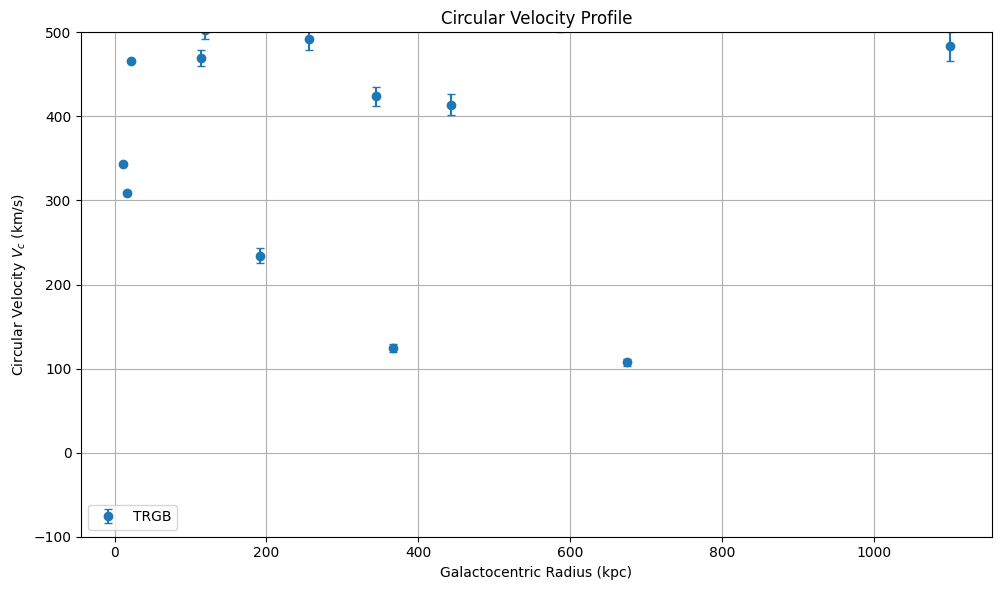

In [ ]:
r_spatial = r[spatial_mask]
V_r_spatial = V_r[spatial_mask]
V_th_spatial = V_theta[spatial_mask]
V_ph_spatial = V_phi[spatial_mask]
# ----------------------------------------
# 6. Robust dispersion estimator
# ----------------------------------------
def robust_sigma(data):
    y = np.array(data, dtype=float).ravel()
    if y.size == 0:
        return np.nan
    y0 = np.median(y)
    mad = np.median(np.abs(y - y0)) / 0.6745
    if mad < 1e-20:
        mad = np.mean(np.abs(y - y0)) / 0.80
    u = (y - y0) / (6.0 * mad)
    mask_u = np.abs(u) <= 1.0
    if mask_u.sum() < 3:
        return np.nan
    u2 = u[mask_u]**2
    y_core = y[mask_u]
    num = np.sum((y_core - y0)**2 * (1 - u2)**4)
    den = np.sum((1 - u2) * (1 - 5.0 * u2))
    sigma2 = len(y) * num / (den * (den - 1))
    return np.sqrt(sigma2) if sigma2 > 0 else 0.0

# ----------------------------------------
# 7. Bin and compute statistics
# ----------------------------------------
bin_edges = np.histogram_bin_edges(r_valid, bins='fd')
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

def compute_binned_stats(r, v):
    stats = []
    for i in range(len(bin_centers)):
        mask = (r >= bin_edges[i]) & (r < bin_edges[i+1])
        if np.sum(mask) >= 3:
            v_bin = v[mask]
            sig = robust_sigma(v_bin)
            err = sig / np.sqrt(2 * (np.sum(mask) - 1))
            med = np.median(v_bin)
        else:
            sig = err = med = np.nan
        stats.append((med, sig, err))
    return np.array(stats).T

medVr, sigVr, errVr = compute_binned_stats(r_valid, V_r_valid)
medVt, sigVt, errVt = compute_binned_stats(r_valid, V_th_valid)
medVp, sigVp, errVp = compute_binned_stats(r_valid, V_ph_valid)

# Anisotropy
beta = 1 - (sigVt**2 + sigVp**2) / (2 * sigVr**2)
d_beta_dsr = (sigVt**2 + sigVp**2) / (sigVr**3)
d_beta_dst = -sigVt / (sigVr**2)
d_beta_dsp = -sigVp / (sigVr**2)
beta_err = np.sqrt((d_beta_dsr * errVr)**2 +
                   (d_beta_dst * errVt)**2 +
                   (d_beta_dsp * errVp)**2)

# ----------------------------------------
# 8. Plot results
# ----------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

# Scatter plot of velocities
axes[0, 0].scatter(r_valid, V_r_valid, s=1, alpha=0.5, label='$V_r$')
axes[0, 0].scatter(r_valid, V_th_valid, s=1, alpha=0.5, label='$V_\\theta$')
axes[0, 0].scatter(r_valid, V_ph_valid, s=1, alpha=0.5, label='$V_\\phi$')
axes[0, 0].set(xlabel='r [kpc]', ylabel='Velocity [km/s]', xscale='log', ylim=(-800, 800))
axes[0, 0].legend(fontsize='small')
axes[0, 0].set_title("Galactocentric Velocities (|Z| > 5 kpc)")

# Robust dispersions
axes[0, 1].errorbar(bin_centers, sigVr, yerr=errVr, fmt='o', label='$\\sigma(V_r)$')
axes[0, 1].errorbar(bin_centers, sigVt, yerr=errVt, fmt='s', label='$\\sigma(V_\\theta)$')
axes[0, 1].errorbar(bin_centers, sigVp, yerr=errVp, fmt='^', label='$\\sigma(V_\\phi)$')
axes[0, 1].set(xlabel='r [kpc]', ylabel='Dispersion [km/s]', xlim=(0, 200))
axes[0, 1].legend(fontsize='small')
axes[0, 1].set_title("Velocity Dispersions")

# Medians
axes[1, 0].plot(bin_centers, medVr, 'o-', label='$\\mathrm{median}(V_r)$')
axes[1, 0].plot(bin_centers, medVt, 's-', label='$\\mathrm{median}(V_\\theta)$')
axes[1, 0].plot(bin_centers, medVp, '^-', label='$\\mathrm{median}(V_\\phi)$')
axes[1, 0].set(xlabel='r [kpc]', ylabel='Median Velocity', xlim=(0, 200))
axes[1, 0].legend(fontsize='small')
axes[1, 0].set_title("Median Velocities")

# Beta
axes[1, 1].errorbar(bin_centers, beta, yerr=beta_err, fmt='d', label='$\\beta(r)$')
axes[1, 1].axhline(0, color='gray', linestyle='--')
axes[1, 1].set(xlabel='r [kpc]', ylabel='$\\beta$', xscale='log', xlim=(0.5, 100), ylim=(-5, 2))
axes[1, 1].legend(fontsize='small')
axes[1, 1].set_title("Anisotropy Parameter")

plt.tight_layout()
plt.show()


In [9]:
# ----------------------------------------
# 6. Robust dispersion estimator
# ----------------------------------------
def robust_sigma(data):
    y = np.array(data, dtype=float).ravel()
    if y.size == 0:
        return np.nan
    y0 = np.median(y)
    mad = np.median(np.abs(y - y0)) / 0.6745
    if mad < 1e-20:
        mad = np.mean(np.abs(y - y0)) / 0.80
    u = (y - y0) / (6.0 * mad)
    mask_u = np.abs(u) <= 1.0
    if mask_u.sum() < 3:
        return np.nan
    u2 = u[mask_u]**2
    y_core = y[mask_u]
    num = np.sum((y_core - y0)**2 * (1 - u2)**4)
    den = np.sum((1 - u2) * (1 - 5.0 * u2))
    sigma2 = len(y) * num / (den * (den - 1))
    return np.sqrt(sigma2) if sigma2 > 0 else 0.0

# ----------------------------------------
# 7. Bin and compute statistics
# ----------------------------------------
def compute_binned_stats(r, v, bin_edges):
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    stats = []
    for i in range(len(bin_centers)):
        mask = (r >= bin_edges[i]) & (r < bin_edges[i+1])
        if np.sum(mask) >= 3:
            v_bin = v[mask]
            sig = robust_sigma(v_bin)
            err = sig / np.sqrt(2 * (np.sum(mask) - 1))
            med = np.median(v_bin)
        else:
            sig = err = med = np.nan
        stats.append((med, sig, err))
    return bin_centers, np.array(stats).T  # returns: bin_centers, (med, sig, err)

# ----------------------------------------
# 8. Compute anisotropy β and its error
# ----------------------------------------
def compute_beta_anisotropy(r_valid, V_r_valid, V_th_valid, V_ph_valid, bin_edges):
    bin_centers, (medVr, sigVr, errVr) = compute_binned_stats(r_valid, V_r_valid, bin_edges)
    _, (medVt, sigVt, errVt) = compute_binned_stats(r_valid, V_th_valid, bin_edges)
    _, (medVp, sigVp, errVp) = compute_binned_stats(r_valid, V_ph_valid, bin_edges)

    # Anisotropy
    beta = 1 - (sigVt**2 + sigVp**2) / (2 * sigVr**2)

    # Error propagation
    d_beta_dsr = (sigVt**2 + sigVp**2) / (sigVr**3)
    d_beta_dst = -sigVt / (sigVr**2)
    d_beta_dsp = -sigVp / (sigVr**2)

    beta_err = np.sqrt((d_beta_dsr * errVr)**2 +
                       (d_beta_dst * errVt)**2 +
                       (d_beta_dsp * errVp)**2)

    return bin_centers, beta, beta_err
for config in file_configs:
    _, _, binned_df,r, z, V_r, V_theta, V_phi = process_file_with_selection(config['path'], config['label'], config['bins'])
    r_vals = binned_df['Bin Center'].values
    std_vals = binned_df['Std Y'].values
    N_vals = binned_df['Num Points'].values

    # Get beta & beta_err for these r_vals
    bin_centers, beta_vals, beta_err_vals = compute_beta_anisotropy(
        r_valid, V_r_valid, V_th_valid, V_ph_valid, config['bins']
    )

    r_vals_q, std_vals_q = r_vals * u.kpc, std_vals * u.km/u.s
    b_low, b_high, b_s = fit_params[config['label']]['b_low'], fit_params[config['label']]['b_high'], fit_params[config['label']]['b_s']

    r_plot, V_c_vals, V_c_err = compute_v_c(
        r_vals_q, std_vals_q, N_vals, beta_vals, beta_err_vals, b_low, b_high, b_s
    )

    plt.errorbar(r_plot.value, V_c_vals, yerr=V_c_err, fmt='o', capsize=3, label=f'{config["label"]}')


NameError: name 'r_valid' is not defined

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_8296\3117966961.py:8: RuntimeWarning: divide by zero encountered in divide
  error_sigma_r = np.sqrt(1 / (2 * (N - 1))) * sigma_r
c:\Users\Lenovo\AppData\Local\Programs\Python\Python38\lib\site-packages\astropy\units\quantity.py:673: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python38\lib\site-packages\astropy\units\quantity.py:673: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


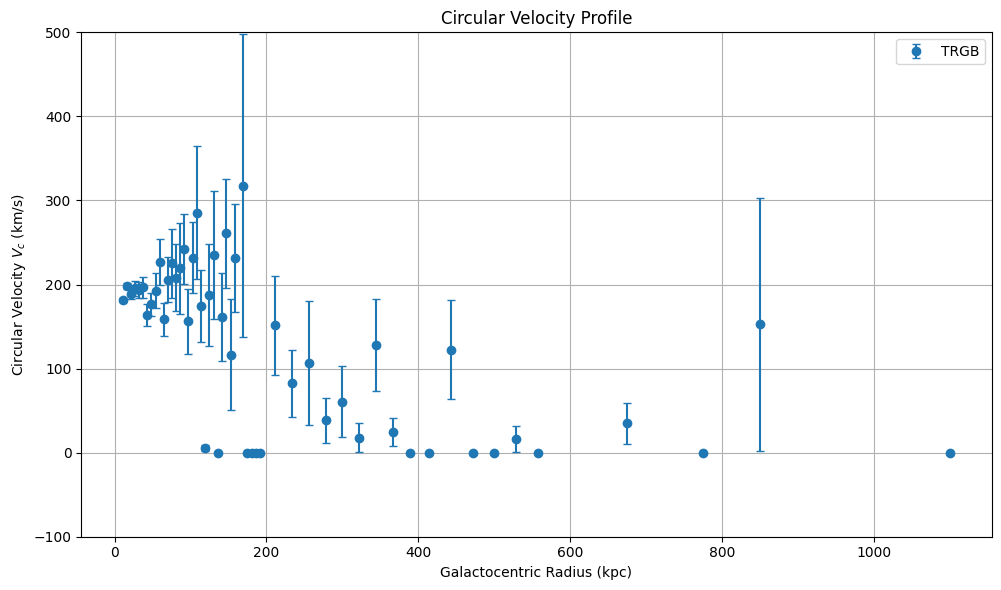

In [6]:
# V_c computation
def compute_v_c(r, std_y, N, b_low, b_high, b_s):
    H_r = (r**2 + R0**2) / (4 * r**2) - ((r**2 - R0**2)**2) / (8 * r**3 * R0) * np.log(abs((r + R0) / (r - R0)))
    sigma_r = std_y / np.sqrt(1 - beta * H_r)
    dln_ntr_dlR = np.where(r.value < 200, b_low, b_high)
    dln_sigma_r2_dlR = b_s
    V_c = np.sqrt(np.abs(-sigma_r**2 * (dln_ntr_dlR + dln_sigma_r2_dlR + 2 * beta)))
    error_sigma_r = np.sqrt(1 / (2 * (N - 1))) * sigma_r
    error_V_c = np.sqrt((2 * sigma_r * error_sigma_r / V_c)**2 + (sigma_r**2 / (V_c * N))**2)
    return r, V_c, error_V_c
beta=0
plt.figure(figsize=(10, 6))
for config in file_configs:
    _, _, binned_df = process_file_with_selection(config['path'], config['label'], config['bins'])
    r_vals, std_vals, N_vals = binned_df['Bin Center'].values, binned_df['Std Y'].values, binned_df['Num Points'].values
    r_vals_q, std_vals_q = r_vals * u.kpc, std_vals * u.km/u.s
    b_low, b_high, b_s = fit_params[config['label']]['b_low'], fit_params[config['label']]['b_high'], fit_params[config['label']]['b_s']
    r_plot, V_c_vals, V_c_err = compute_v_c(r_vals_q, std_vals_q, N_vals, b_low, b_high, b_s)
    plt.errorbar(r_plot.value, V_c_vals, yerr=V_c_err, fmt='o', capsize=3, label=f'{config["label"]}')
plt.xlabel('Galactocentric Radius (kpc)')
plt.ylabel('Circular Velocity $V_c$ (km/s)')
plt.title('Circular Velocity Profile')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.ylim(-100,500)
plt.show()

NameError: name 'np' is not defined